In [1]:
import numpy as np
import matplotlib.pyplot as plt

DT = np.float32
learning_rate = .001

# Education Framework (EdF)

### Clearing the Computation graph
This should be done immediately before creating a new computation graph.

In [2]:
def clear_compgraph():
    global CompNodes, Parameters
    CompNodes = []
    Parameters = []

### Forward-Backward and SGD 

In [3]:
def Forward():
    for c in CompNodes: # propogate in order
        c.forward()

def Backward(loss):
    for c in CompNodes + Parameters:
        c.grad = np.zeros(c.value.shape, dtype = DT)
    loss.grad = np.ones(loss.value.shape) / len(loss.value)  # The convention is to compute the averaage gradient over the batch
    for c in CompNodes[::-1]: # propogate in the reverse order
        c.backward()

def SGD():
    for p in Parameters: 
        p.SGD()

### Computation Graphs
There are three kinds of nodes in a computation graph, inputs, parameters, and computed nodes (CompNodes).
Computed nodes are defined on a case by case bases.  The Sigmoid class is defined as an example.  Other classes are
defined below.

In [4]:
class Input:
    def __init__(self):
        pass

    def addgrad(self, delta):
        pass
        
class Parameter:
    def __init__(self, value):
        self.value = DT(value)
        Parameters.append(self)

    def addgrad(self, delta):
        self.grad += np.sum(delta, axis = 0)

    def SGD(self):
        self.value -= learning_rate*self.grad

class CompNode:
    def addgrad(self, delta):
        self.grad += delta

### Parameter Packages and some Compnodes

In [5]:
class ParameterPackage:
    pass
    
class AffineParams(ParameterPackage):
    def __init__(self, nInputs, nOutputs):
        X = Xavier(nInputs)
        self.w = Parameter(np.random.uniform(-X,X,(nInputs,nOutputs)))
        self.b = Parameter(np.zeros(nOutputs))

def Xavier(nInputs):
    return np.sqrt(3.0/nInputs)

class Affine(CompNode):
    def __init__(self,Phi,x):
        CompNodes.append(self)
        self.x = x
        self.Phi = Phi

    def forward(self):
        self.value = np.matmul(self.x.value, self.Phi.w.value) + self.Phi.b.value # the addition broadcasts b over the batch.
 
    def backward(self):
        self.x.addgrad(np.matmul(self.grad, self.Phi.w.value.transpose()))
        self.Phi.b.addgrad(self.grad)
        self.Phi.w.addgrad(self.x.value[:,:,np.newaxis] * self.grad[:,np.newaxis,:])

class Sigmoid(CompNode):
    def __init__(self,x):
        CompNodes.append(self)
        self.x = x

    def forward(self):
        bounded = np.maximum(-10, np.minimum(10,self.x.value)) #blocks numerical warnings
        self.value = 1 / (1 + np.exp(-bounded))

    def backward(self):
        self.x.addgrad(self.grad * self.value * (1-self.value))

class Softmax(CompNode):
    def __init__(self,s): #s has shape (nBatch,nLabels}
        CompNodes.append(self)
        self.s = s
        
    def forward(self):
        smax = np.max(self.s.value,axis=1,keepdims=True)
        bounded = np.maximum(-10,self.s.value - smax) #blocks numerical warnings
        es = np.exp(bounded) 
        self.value = es / np.sum(es,axis=1,keepdims=True)

    def backward(self):
        p_dot_pgrad = np.matmul(self.value[:,np.newaxis,:],self.grad[:,:,np.newaxis]).squeeze(-1) # p dot p.grad with shape (nBatch,1)
        self.s.addgrad(self.value * (self.grad - p_dot_pgrad)) # p_dot_pgrad is broadcast over the labels

class LogLoss(CompNode):
    def __init__(self,p,y):
        if not isinstance(p,CompNode):
            print('LogLoss probability vector is not a CompNode')
            raise ValueError
        CompNodes.append(self)
        self.p = p
        self.y = y

    def forward(self):
        dLabels = self.p.value.shape[1]
        dBatch = len(self.y.value)
        self.picker = np.arange(dBatch)*dLabels + self.y.value  # p.flatten[picker][b] =p[b,y[b]] where b is the batch index
        self.value = - np.log(self.p.value.reshape((-1,))[self.picker])
        
    def backward(self):
        flatpval = self.p.value.reshape((-1,))
        flatpgrad = self.p.grad.reshape((-1,))
        flatpgrad[self.picker] -= self.grad/flatpval[self.picker]

# Example using the MNIST Handwritten Digit Database

In [6]:
from __future__ import division, print_function, absolute_import
import os
import struct
from array import array
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Mnist Loader 

In [7]:


def load_mnist(section="training", offset=0, count=None, ret='xy',
               x_dtype=np.float64, y_dtype=np.int64, path=None):
    """
    Loads MNIST files into a 3D numpy array.
    You have to download the data separately from [MNIST]_. It is recommended
    to set the environment variable ``MNIST_DIR`` to point to the folder where
    you put the data, so that you don't have to select path. On a Linux+bash
    setup, this is done by adding the following to your ``.bashrc``::
        export MNIST_DIR=/path/to/mnist
    Parameters
    ----------
    section : str
        Either "training" or "testing", depending on which section you want to
        load.
    offset : int
        Skip this many samples.
    count : int or None
        Try to load this many samples. Default is None, which loads until the
        end.
    ret : str
        What information to return. See return values.
    x_dtype : dtype
        Type of samples. If ``np.uint8``, intensities lie in {0, 1, ..., 255}.
        If a float type, then intensities lie in [0.0, 1.0].
    y_dtype : dtype
        Integer type to store labels.
    path : str
        Path to your MNIST datafiles. The default is ``None``, which will try
        to take the path from your environment variable ``MNIST_DIR``. The data
        can be downloaded from http://yann.lecun.com/exdb/mnist/.
    Returns
    -------
    images : ndarray
        Image data of shape ``(N, 28, 28)``, where ``N`` is the number of
        images. Returned if ``ret`` contains ``'x'``.
    labels : ndarray
        Array of size ``N`` describing the labels. Returned if ``ret``
        contains ``'y'``.
    Examples
    --------
    Assuming that you have downloaded the MNIST database and set the
    environment variable ``$MNIST_DIR`` point to the folder, this will load all
    images and labels from the training set:
    >>> images, labels = ag.io.load_mnist('training')  # doctest: +SKIP
    Load 100 samples from the testing set:
    >>> sevens = ag.io.load_mnist('testing', offset=200, count=100,
                                  ret='x') # doctest: +SKIP
    """

    # The files are assumed to have these names and should be found in 'path'
    files = {
        'training': ('train-images-idx3-ubyte',
                     'train-labels-idx1-ubyte',
                     60000),
        'testing': ('t10k-images-idx3-ubyte',
                    't10k-labels-idx1-ubyte',
                    10000),
    }
    
    resources = {
        'training' : ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
                      'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'],
        'testing' : ['http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
                     'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'],
    }
                         
    if count is None:
        count = files[section][2] - offset

    if path is None:
        try:
            path = os.environ['MNIST_DIR']
        except KeyError:
            raise ValueError("Unspecified path requires the environment"
                             "variable $MNIST_DIR to be set")

    try:
        images_fname = os.path.join(path, files[section][0])
        labels_fname = os.path.join(path, files[section][1])
    except KeyError:
        raise ValueError("Data set must be 'testing' or 'training'")

    if not (os.path.exists(images_fname) and os.path.exists(labels_fname)):
        try:
            if not os.path.exists(path):
                os.makedirs(path)
            
            for resource in resources[section]:
                import urllib, gzip
                filename = resource.rpartition('/')[2]
                fpath = os.path.join(path, filename)
                urllib.request.urlretrieve(resource, fpath)
                with open(fpath.replace('.gz',''), "wb") as out_f, gzip.GzipFile(fpath) as zip_f:
                    out_f.write(zip_f.read())
        except KeyError:
            raise ValueError("Failed to download data. Collect it manually from http://yann.lecun.com/exdb/mnist/")
            
    returns = ()
    if 'x' in ret:
        with open(images_fname, 'rb') as fimg:
            magic_nr, size, d0, d1 = struct.unpack(">IIII", fimg.read(16))
            fimg.seek(offset * d0 * d1, 1)
            images_raw = array("B", fimg.read(count * d0 * d1))

        images = np.asarray(images_raw, dtype=x_dtype).reshape(-1, d0, d1)
        if x_dtype == np.uint8:
            pass  # already this type
        elif x_dtype in (np.float16, np.float32, np.float64):
            images /= 255.0
        else:
            raise ValueError("Unsupported value for x_dtype")

        returns += (images,)

    if 'y' in ret:
        with open(labels_fname, 'rb') as flbl:
            magic_nr, size = struct.unpack(">II", flbl.read(8))
            flbl.seek(offset, 1)
            labels_raw = array("b", flbl.read(count))

        labels = np.asarray(labels_raw)

        returns += (labels,)

    if len(returns) == 1:
        return returns[0]  # Don't return a tuple of one
    else:
        return returns

In [8]:
train_images, train_labels = load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = load_mnist(section = 'testing', path = 'MNIST')

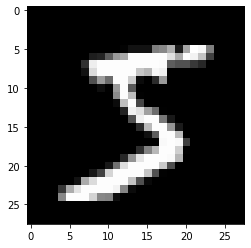

In [9]:
plt.imshow(train_images[0], cmap='gray', interpolation = 'nearest')
plt.show()

In [10]:
"""we will reshape the 28x28 grayscale images as 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [11]:
"""we manually set the number of input features (784)
and number of classes (10) which will be used to
define the model"""

nInputs = 784
nLabels = 10

"""below, MLPparams is an EDF ParameterPackage whose
purpose is to define and store the parameters of the model,
while MLPgraph is a function that implements the model's
forward pass -- in this case, just a 1-hidden layer MLP"""

class MLPparams(ParameterPackage):
    def __init__(self,nInputs, nHiddens, nLabels):
        self.first = AffineParams(nInputs,nHiddens)
        self.last = AffineParams(nHiddens,nLabels)
        
def MLPsigmoidgraph(Phi, x):
    h = Sigmoid(Affine(Phi.first, x))
    return Softmax(Affine(Phi.last, h))

"""we then construct a MLP with 64 hidden units"""

np.random.seed(1234)
clear_compgraph()
xnode = Input()
ynode = Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPsigmoidgraph(Phi, xnode)
lossnode = LogLoss(probnode, ynode)

In [12]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""

def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        xnode.value = train_images[start:end]
        ynode.value = train_labels[start:end]
        Forward()
        total_err += np.sum(np.not_equal(np.argmax(probnode.value, axis=1), ynode.value))
        if lossnode:
            Backward(lossnode)
            SGD()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_err = run_epoch(batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(len(test_images), test_images, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

In [13]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.37 %
	 Test Error 5.77 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 4.56 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 3.78 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.49 %
	 Test Error 3.25 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.09 %
	 Test Error 2.85 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.78 %
	 Test Error 2.60 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.49 %
	 Test Error 2.35 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.24 %
	 Test Error 2.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.01 %
	 Test Error 2.06 %


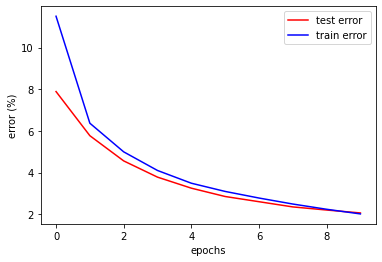

<Figure size 432x288 with 0 Axes>

In [14]:
"""we can then plot the error per epoch on the training and test data"""

plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [15]:
"""next, we can implement a ReLU activation function ReLU(x) = max(0,x)"""

class ReLU(CompNode):
    def __init__(self, x):
        CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = np.maximum(0, self.x.value)

    def backward(self):
        self.x.addgrad(self.grad * (self.x.value > 0))
        

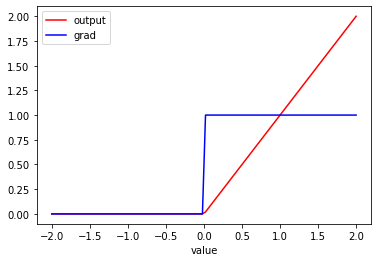

<Figure size 432x288 with 0 Axes>

In [16]:
"""the code below will plot the output and gradients computed by our
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of our implementation."""

values = np.linspace(-2,2,100)
clear_compgraph()
param = Parameter(values[None, :])
output = ReLU(param)

Forward()
Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [17]:
"""now, train the same network as before but with a ReLU activation
in the hidden layer instead of a Sigmoid."""

def MLPrelugraph(Phi, x):
    h = ReLU(Affine(Phi.first, x))
    return Softmax(Affine(Phi.last, h))

np.random.seed(1234)
clear_compgraph()
xnode = Input()
ynode = Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPrelugraph(Phi, xnode)
lossnode = LogLoss(probnode, ynode)

In [18]:
num_epochs = 10
batch_size = 64
learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.50 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.08 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.72 %
	 Test Error 2.79 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.16 %
	 Test Error 2.49 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.79 %
	 Test Error 2.12 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.50 %
	 Test Error 2.00 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.36 %
	 Test Error 2.20 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.10 %
	 Test Error 1.88 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.99 %
	 Test Error 1.57 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.85 %
	 Test Error 1.31 %


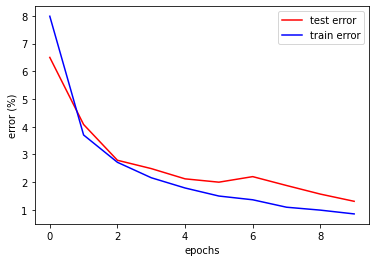

<Figure size 432x288 with 0 Axes>

In [19]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [20]:
"""now, implement the Tanh activation function"""

class Tanh(CompNode):
    def __init__(self, x):
        CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here
        self.value = (np.exp(self.x.value) - np.exp(-self.x.value)) / (np.exp(self.x.value) + np.exp(-self.x.value))

    def backward(self):
        # implementation goes here
        self.x.addgrad(self.grad * (1 - ((np.exp(self.x.value) - np.exp(-self.x.value)) / (np.exp(self.x.value) + np.exp(-self.x.value)))**2))

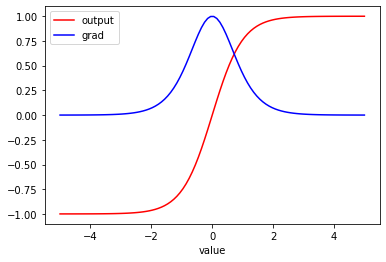

<Figure size 432x288 with 0 Axes>

In [21]:
"""again, make sure that the output and gradients plotted below are correct."""

values = np.linspace(-5,5,100)
clear_compgraph()
param = Parameter(values[None, :])
output = Tanh(param)

Forward()
Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color='red')
plt.plot(values, param.grad[0], color='blue')
plt.legend(['output', 'grad'], loc='upper left')
plt.show()
plt.clf()

In [22]:
"""we can then train a network with a Tanh activation function instead of Sigmoid/ReLU."""

def MLPtanhgraph(Phi, x):
    h = Tanh(Affine(Phi.first, x))
    return Softmax(Affine(Phi.last, h))

np.random.seed(1234)
clear_compgraph()
xnode = Input()
ynode = Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPtanhgraph(Phi, xnode)
lossnode = LogLoss(probnode, ynode)

In [23]:
num_epochs = 10
batch_size = 64
learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.29 %
	 Test Error 6.01 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.21 %
	 Test Error 4.13 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.05 %
	 Test Error 2.93 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.38 %
	 Test Error 2.26 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.95 %
	 Test Error 1.82 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.60 %
	 Test Error 1.60 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.31 %
	 Test Error 1.41 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.07 %
	 Test Error 1.28 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.84 %
	 Test Error 1.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.66 %
	 Test Error 1.21 %


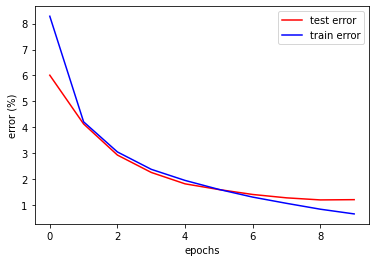

<Figure size 432x288 with 0 Axes>

In [24]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [25]:
"""next, let's check how changing the learning rate affects
the model's train and test error (w/ sigmoid and w/ relu activations)"""

num_epochs = 5
batch_size = 64
learning_rates = [5.0, 1.0, 0.5, 0.1]

train_err_per_lr = []
test_err_per_lr = []

# implementation goes here
for lr in learning_rates:
    np.random.seed(1234)
    clear_compgraph()
    xnode = Input()
    ynode = Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = LogLoss(probnode, ynode)
    learning_rate = lr
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])

Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.90 %
	 Test Error 7.51 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.98 %
	 Test Error 6.27 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 5.59 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.41 %
	 Test Error 4.72 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.87 %
	 Test Error 4.53 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.96 %
	 Test Error 4.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.71 %
	 Test Error 3.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.98 %
	 Test Error 2.86 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.51 %
	 Test Error 2.39 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/9

In [26]:
best_sigmoid_lr = learning_rates[test_err_per_lr.index(min(test_err_per_lr))]# implementation goes here

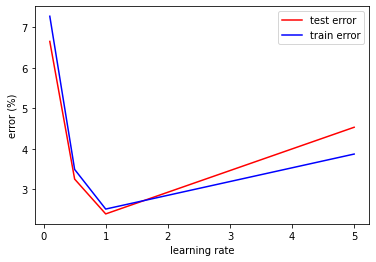

<Figure size 432x288 with 0 Axes>

In [27]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [28]:
"""now, repeat the experiment above but with a MLP with
a ReLU activation functions in the hidden layer"""

train_err_per_lr = []
test_err_per_lr = []

# implementation goes here
for lr in learning_rates:
    np.random.seed(1234)
    clear_compgraph()
    xnode = Input()
    ynode = Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = LogLoss(probnode, ynode)
    learning_rate = lr
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])

Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.10 %
	 Test Error 90.20 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 29.75 %
	 Test Error 23.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 9.58 %
	 Test Error 10.87 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.03 %
	 Test Error 10.19 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.45 %
	 Test Error 9.74 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.13 %
	 Test Error 9.67 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.99 %
	 Test Error 6.50 %
Epoch: 2/5
	 Batch 400/937
	 

In [29]:
best_relu_lr = learning_rates[test_err_per_lr.index(min(test_err_per_lr))]

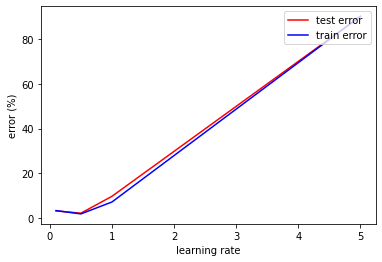

<Figure size 432x288 with 0 Axes>

In [30]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color='red')
plt.plot(learning_rates, train_err_per_lr, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [31]:
"""finally, we will check how the number of hidden layers affects
the model's performance. start by re-implementing MLPparams such that
it supports multiple layers (note the new nLayers argument). each of the
nLayers-1 hidden layers should have nHiddens neurons."""

class MLPparams(ParameterPackage):
    def __init__(self,nInputs, nHiddens, nLabels, nLayers):
        # implementation goes here
        self.layers = [AffineParams(nInputs, nHiddens)] + \
                      [AffineParams(nHiddens, nHiddens) for i in range(nLayers-2)] + \
                      [AffineParams(nHiddens, nLabels)]
        
"""we also re-implement MLPsigmoidgraph and MLPsigmoidgraph
so that they both have support for multiple layers"""
        
def MLPsigmoidgraph(Phi, x):
    # implementation goes here
    h = Sigmoid(Affine(Phi.layers[0], x))
    for i in range(1, len(Phi.layers)-1):
        h = Sigmoid(Affine(Phi.layers[i], h))
    return Softmax(Affine(Phi.layers[-1], h))

def MLPrelugraph(Phi, x):
    # implementation goes here
    h = ReLU(Affine(Phi.layers[0], x))
    for i in range(1, len(Phi.layers)-1):
        h = ReLU(Affine(Phi.layers[i], h))
    return Softmax(Affine(Phi.layers[-1], h))

In [32]:
"""similarly to the exploration with different learning rates,
we will see how the depth of the network affects its performance,
first for a sigmoid network. fill the missing code to populate
train_err_per_depth and test_err_per_depth accordingly"""

learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here
for nl in num_layers:
    np.random.seed(1234)
    clear_compgraph()
    xnode = Input()
    ynode = Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels, nl)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = LogLoss(probnode, ynode)
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])

Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.96 %
	 Test Error 4.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.71 %
	 Test Error 3.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.98 %
	 Test Error 2.86 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.51 %
	 Test Error 2.39 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 29.66 %
	 Test Error 11.85 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.59 %
	 Test Error 7.13 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.45 %
	 Test Error 5.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.43 %
	 Test Error 4.33 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.75 %
	 Test Error 3.33 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 89.78 %
	 Test Error 89.30 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800

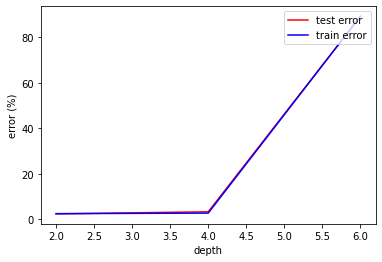

<Figure size 432x288 with 0 Axes>

In [33]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()

In [34]:
"""repeat the above experiment but for a ReLU MLP"""

learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_layers = [3, 5, 10]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here
for nl in num_layers:
    np.random.seed(1234)
    clear_compgraph()
    xnode = Input()
    ynode = Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels, nl)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = LogLoss(probnode, ynode)
    train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])

Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.04 %
	 Test Error 7.78 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.32 %
	 Test Error 4.53 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.24 %
	 Test Error 3.67 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.72 %
	 Test Error 3.22 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.31 %
	 Test Error 2.38 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 21.55 %
	 Test Error 10.29 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.56 %
	 Test Error 6.50 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.16 %
	 Test Error 5.43 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.54 %
	 Test Error 4.51 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.96 %
	 Test Error 4.88 %
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 66.35 %
	 Test Error 41.56 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800

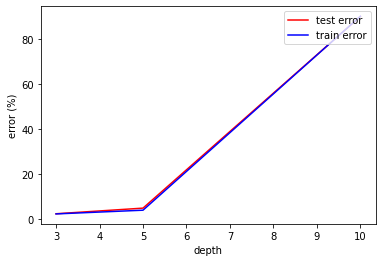

<Figure size 432x288 with 0 Axes>

In [35]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color='red')
plt.plot(num_layers, train_err_per_depth, color='blue')
plt.legend(['test error', 'train error'], loc='upper right')
plt.show()
plt.clf()